In [85]:
# Import Library
import numpy as np 
import pandas as pd 
import pandas_profiling as pp
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster import hierarchy
from sklearn.decomposition import PCA
import warnings
import os
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
warnings.filterwarnings("ignore")
py.offline.init_notebook_mode(connected = True)

In [67]:
# Main Data File Import
df = pd.read_csv('Mall_Customers.csv')
print(df.shape)
df.head()

(200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [68]:
# Basic Exploratory Analysis
print(df.dtypes)
print('---------------------------')
print(df.isnull().sum())

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object
---------------------------
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [69]:
# Basic Exploratory Data Analysis
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [70]:
# In Depth Exploratory Data Analysis
#pp.ProfileReport(df)

Insights: 
1. No correlation between variables
2. Annual income more than 100 can only found in age range 30-50
3. Annual income vs spending score scatter plot illustrate that 5 cluster can be produced

In [71]:
df.columns.tolist()

['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

In [72]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


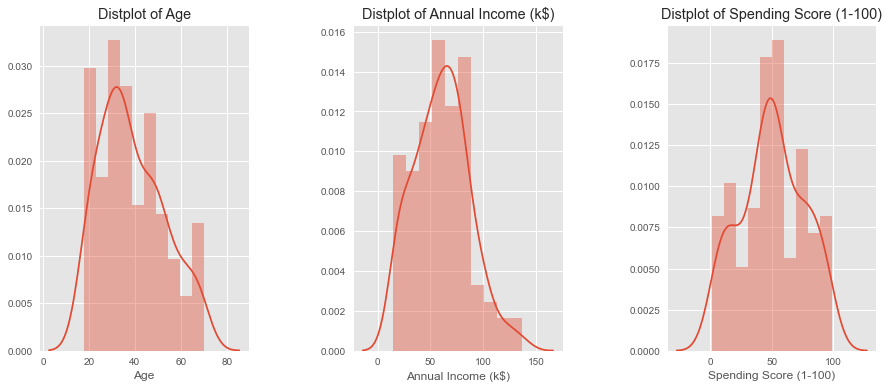

In [73]:
# Basic Exploratory Analysis : Data Visualization
# Understand the distribution of Age, Income, Spending score
plt.style.use('ggplot')
plt.figure(1 , figsize = (15 , 6), clear=True)
n = 0 
for x in df.columns[2:]:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.distplot(df[x] , bins = 10)
    plt.title('Distplot of {}'.format(x))
plt.show()

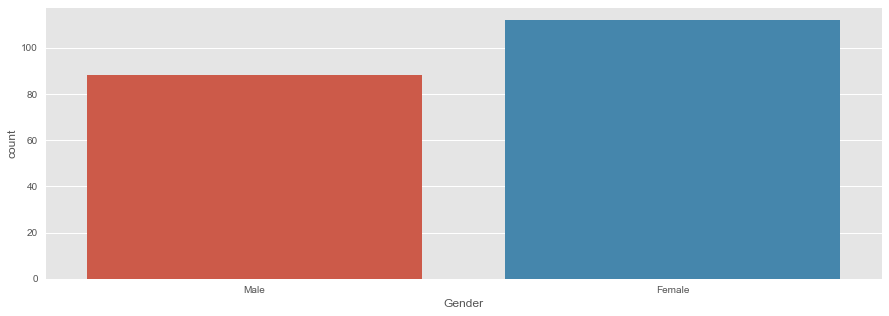

In [74]:
plt.figure(1 , figsize = (15 , 5))
sns.countplot(x = 'Gender' , data = df)
plt.show()

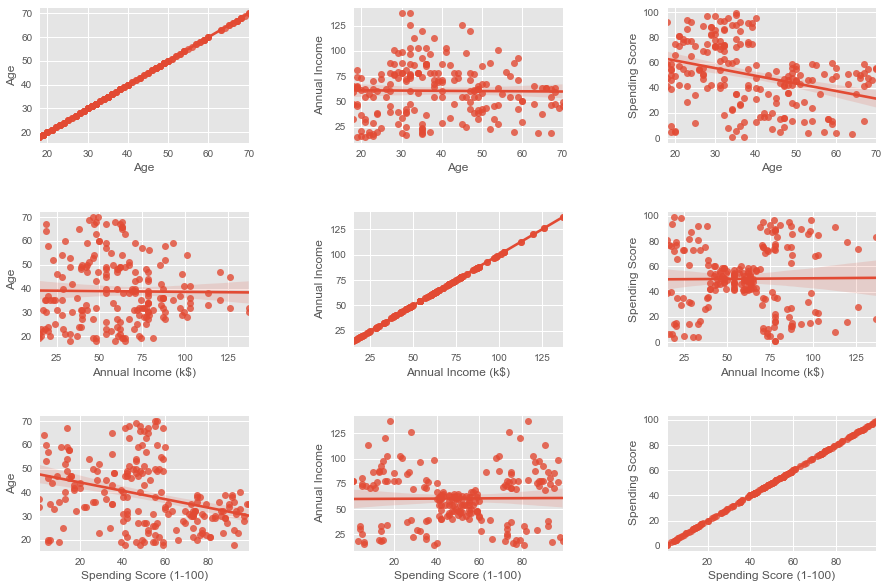

In [75]:
# Relation Between Attributes
plt.figure(1 , figsize = (15 , 10))
n = 0 
for x in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    for y in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
        n += 1
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        sns.regplot(x = x , y = y , data = df)
        plt.ylabel(y.split()[0]+' '+y.split()[1] if len(y.split()) > 1 else y )
plt.show()

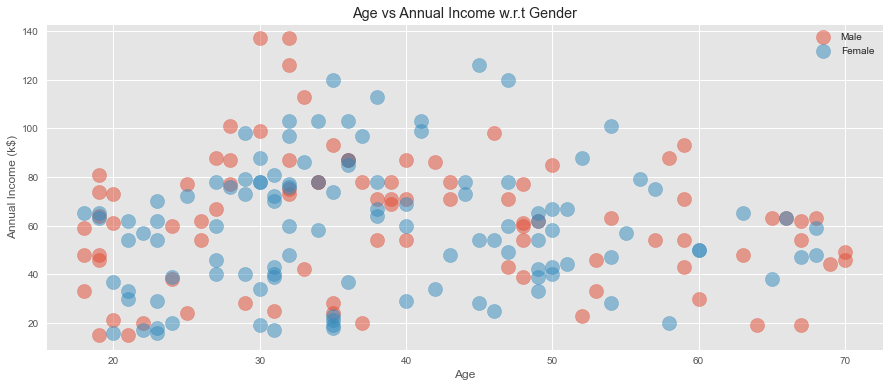

In [76]:
plt.figure(1 , figsize = (15 , 6))
for gender in ['Male' , 'Female']:
    plt.scatter(x = 'Age' , y = 'Annual Income (k$)' , data = df[df['Gender'] == gender] ,
                s = 200 , alpha = 0.5 , label = gender)
plt.xlabel('Age'), plt.ylabel('Annual Income (k$)') 
plt.title('Age vs Annual Income w.r.t Gender')
plt.legend()
plt.show()

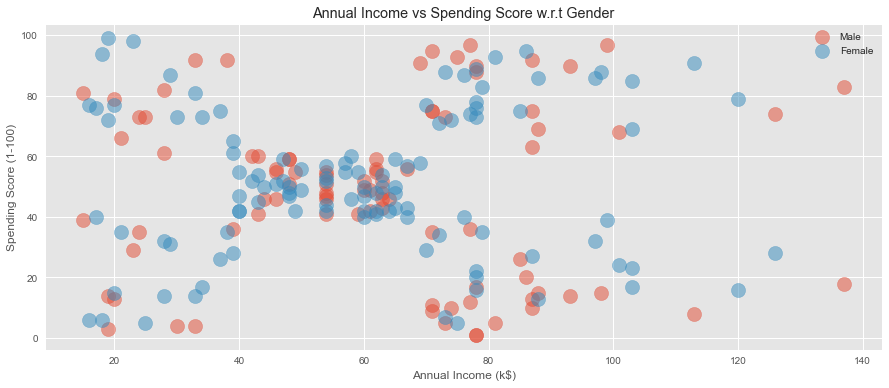

In [77]:
plt.figure(1 , figsize = (15 , 6))
for gender in ['Male' , 'Female']:
    plt.scatter(x = 'Annual Income (k$)',y = 'Spending Score (1-100)' ,
                data = df[df['Gender'] == gender] ,s = 200 , alpha = 0.5 , label = gender)
plt.xlabel('Annual Income (k$)'), plt.ylabel('Spending Score (1-100)') 
plt.title('Annual Income vs Spending Score w.r.t Gender')
plt.legend()
plt.show()

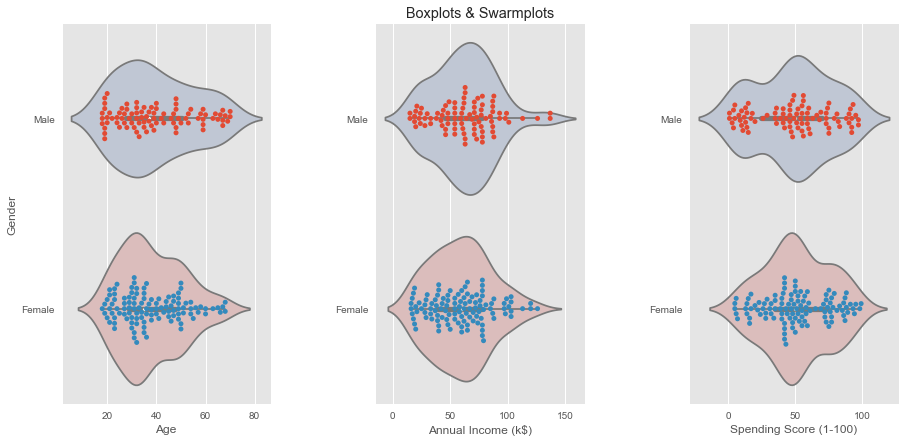

In [78]:
plt.figure(1 , figsize = (15 , 7))
n = 0 
for cols in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    n += 1 
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    sns.violinplot(x = cols , y = 'Gender' , data = df , palette = 'vlag')
    sns.swarmplot(x = cols , y = 'Gender' , data = df)
    plt.ylabel('Gender' if n == 1 else '')
    plt.title('Boxplots & Swarmplots' if n == 2 else '')
plt.show()

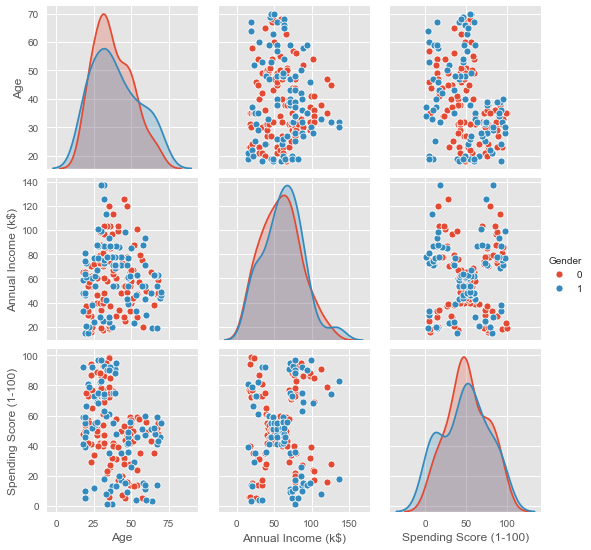

In [87]:
sns.pairplot(df,hue='Gender')

#### Clustering (K-Means)

In [79]:
# Remove Customer ID column
df = df.drop(columns=['CustomerID'], axis=1)
# Dummy Variable Creation 
# df = pd.concat([df, pd.get_dummies(df['Gender'])], axis=1).drop(columns=['Gender'], axis=1)
# Standardization of data
# ss = StandardScaler()
# df[df.columns] = ss.fit_transform(df[df.columns])

#Changing the gender column from categorical to numerical
df.loc[df.Gender == 'Male' ,'Gender'] = 1
df.loc[df.Gender == 'Female' ,'Gender'] = 0

df.Gender= df.Gender.astype(int)

In [80]:
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40


In [81]:
X1 = df.iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 , max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X1)
    inertia.append(algorithm.inertia_)

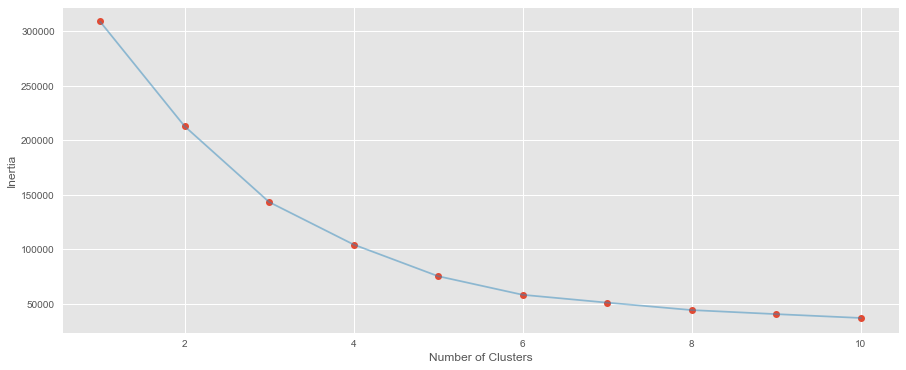

In [82]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

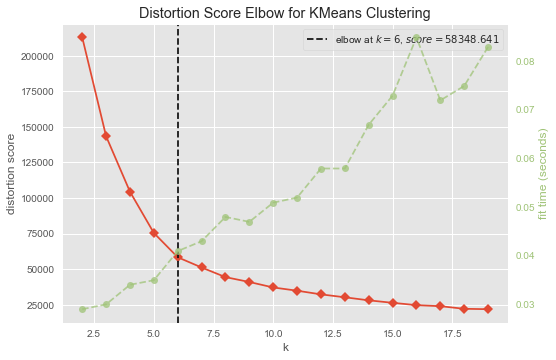

In [83]:
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,20), timings= True)
visualizer.fit(df)        # Fit the data to the visualizer
visualizer.show()       

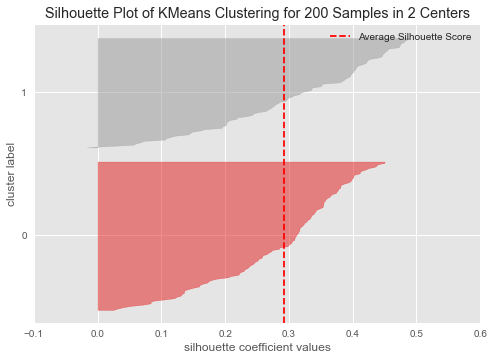

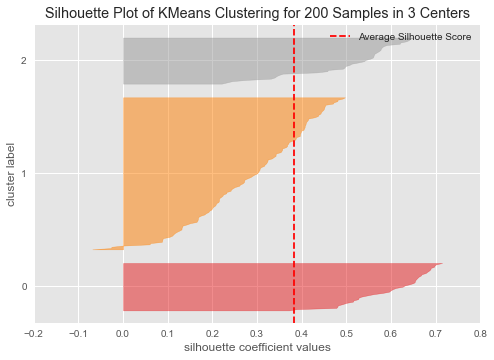

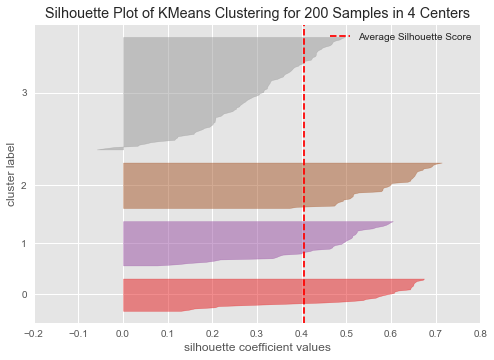

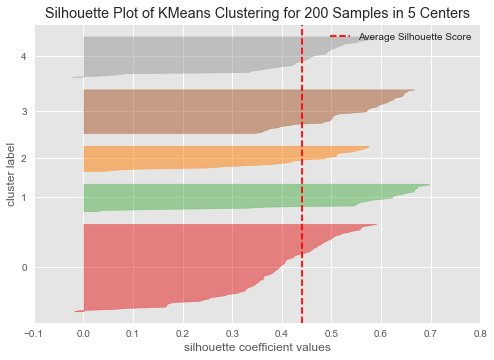

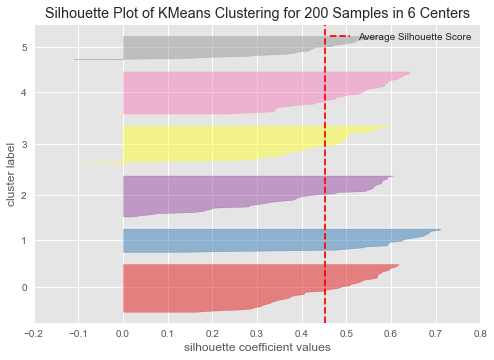

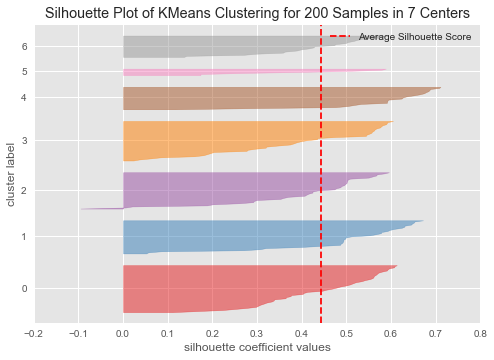

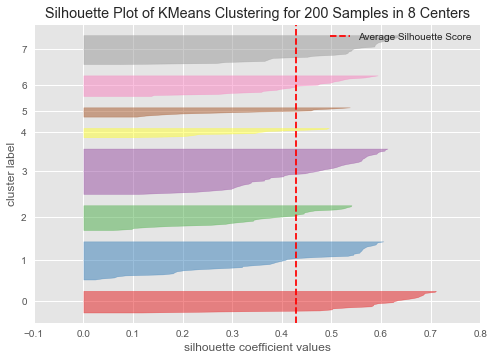

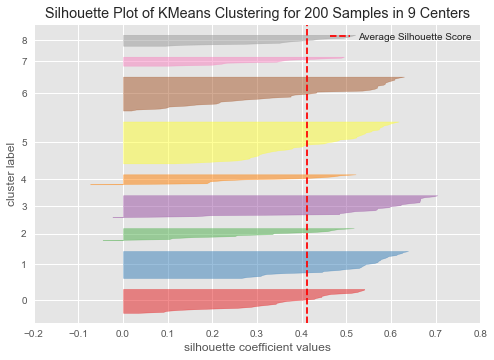

In [86]:
for n in range(2,10):
    model = KMeans(n_clusters = n)
    # k is range of number of clusters.
    visualizer = SilhouetteVisualizer(model)
    visualizer.fit(df)        # Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figure

#### Clustering (Hierarchical)

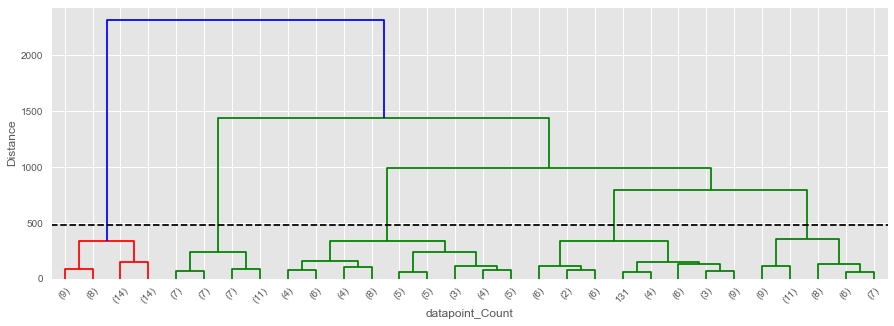

In [41]:
#Note the base n_cluster value of 2 is taken to show the whole tree
ag = AgglomerativeClustering(n_clusters=2, linkage='ward', compute_full_tree=True)
ag = ag.fit(df)
Z = hierarchy.linkage(ag.children_, method='ward')

fig, ax = plt.subplots(figsize=(15,5))

# Some color setup
red = 'red'
blue = 'blue'
threshold = 480

hierarchy.set_link_color_palette([red, 'green'])

den = hierarchy.dendrogram(Z, orientation='top', 
                           p=30, truncate_mode='lastp',
                           show_leaf_counts=True, ax=ax,
                           above_threshold_color=blue)
ax.axhline(y=threshold, c='black',ls='--')
ax.set_ylabel('Distance')
ax.set_xlabel('datapoint_Count')
plt.show()

In [88]:
algorithm = (KMeans(n_clusters = 4 ,init='k-means++', n_init = 10 , max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X1)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

In [89]:
h = 0.02
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()]) 

ValueError: Incorrect number of features. Got 2 features, expected 4

In [120]:
plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z = Z.reshape(xx.shape)
plt.imshow(Z , interpolation='nearest', 
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x = 'Age' ,y = 'Spending Score (1-100)' , data = df , c = labels1 , 
            s = 200 )
plt.scatter(x = centroids1[: , 0] , y =  centroids1[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('Spending Score (1-100)') , plt.xlabel('Age')
plt.show()

ValueError: cannot reshape array of size 13500000 into shape (333,287)

<Figure size 1080x504 with 0 Axes>

In [22]:
'''Annual Income and spending Score'''
X2 = df[['Annual Income (k$)' , 'Spending Score (1-100)']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X2)
    inertia.append(algorithm.inertia_)

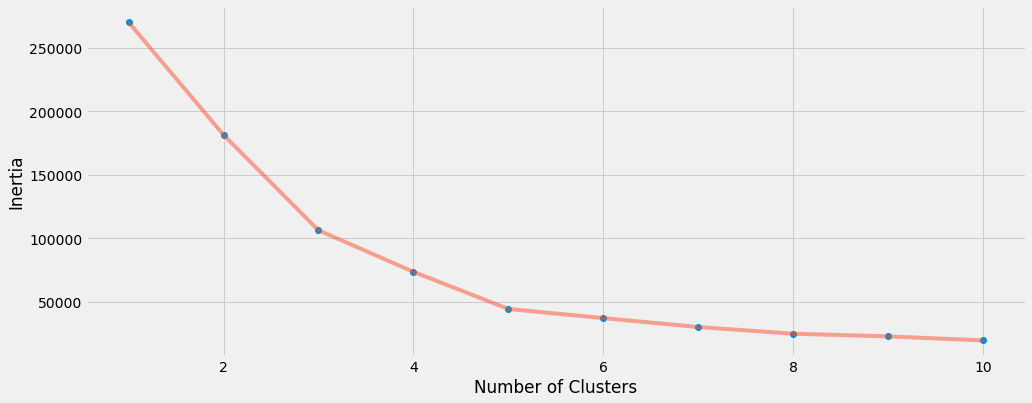

In [23]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

In [24]:
algorithm = (KMeans(n_clusters = 5 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X2)
labels2 = algorithm.labels_
centroids2 = algorithm.cluster_centers_

In [25]:
h = 0.02
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z2 = algorithm.predict(np.c_[xx.ravel(), yy.ravel()]) 

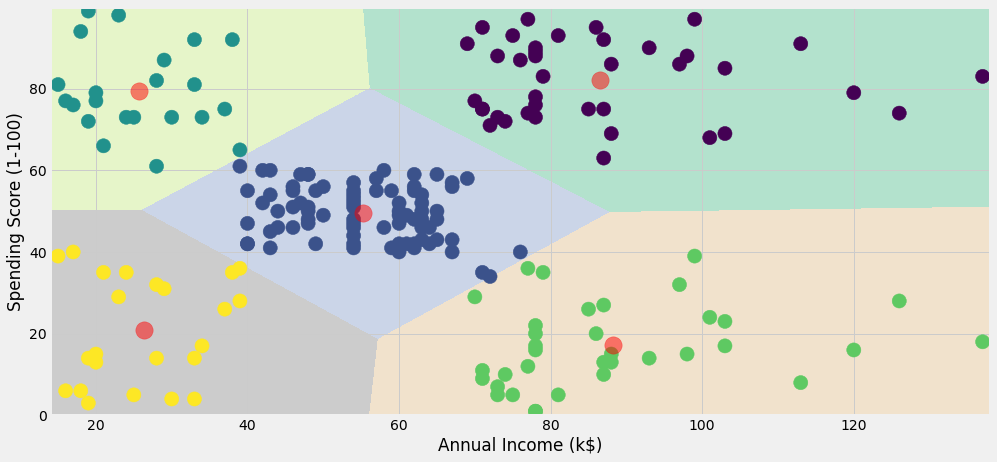

In [26]:
plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z2 = Z2.reshape(xx.shape)
plt.imshow(Z2 , interpolation='nearest', 
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x = 'Annual Income (k$)' ,y = 'Spending Score (1-100)' , data = df , c = labels2 , 
            s = 200 )
plt.scatter(x = centroids2[: , 0] , y =  centroids2[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('Spending Score (1-100)') , plt.xlabel('Annual Income (k$)')
plt.show()

In [27]:
X3 = df[['Age' , 'Annual Income (k$)' ,'Spending Score (1-100)']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X3)
    inertia.append(algorithm.inertia_)

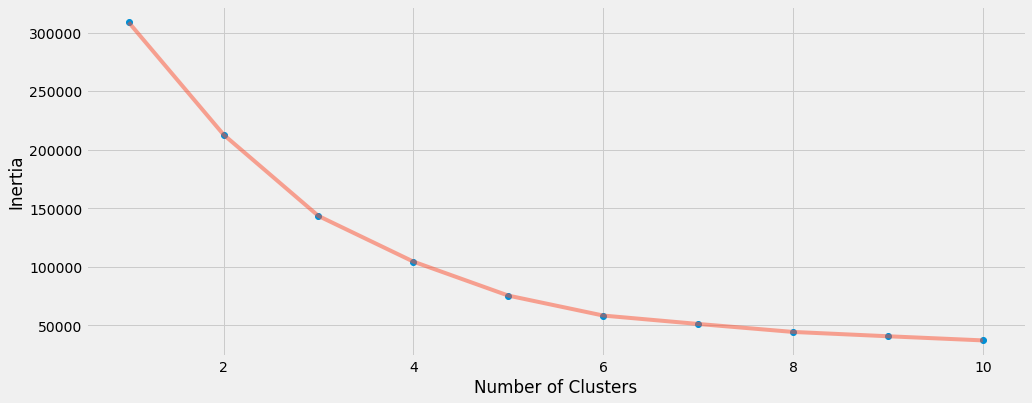

In [28]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

In [29]:
algorithm = (KMeans(n_clusters = 6 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X3)
labels3 = algorithm.labels_
centroids3 = algorithm.cluster_centers_

In [33]:
df['label3'] =  labels3
trace1 = go.Scatter3d(
    x= df['Age'],
    y= df['Spending Score (1-100)'],
    z= df['Annual Income (k$)'],
    mode='markers',
     marker=dict(
        color = df['label3'], 
        size= 20,
        line=dict(
            color= df['label3'],
            width= 12
        ),
        opacity=0.8
     )
)
data = [trace1]
layout = go.Layout(
    title= 'Clusters',
    scene = dict(
            xaxis = dict(title  = 'Age'),
            yaxis = dict(title  = 'Spending Score'),
            zaxis = dict(title  = 'Annual Income')
        )
)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [36]:
fig = px.scatter_3d(df, x=df['Age'], y=df['Spending Score (1-100)'], z=df['Annual Income (k$)'],
              color=df['label3'])
fig.show()

#### PCA and Variance Explanation Analysis

In [43]:
#Checking if we can reduce the number of features by using PCA
dataset_pca = df.iloc[:,:-2]

In [45]:
feature_weight = []
variance_explained = []

# We can select upto 4 features as it is tha max

for n in range(1, 4):
    
    PCAmod = PCA(n_components=n)
    PCAmod.fit(dataset_pca)
    
    # Store the model and variance
    variance_explained.append(PCAmod.explained_variance_ratio_.sum())
    
    # Calculate and store feature importances
    abs_feature_values = np.abs(PCAmod.components_).sum(axis=0)
    feature_weight.append(pd.DataFrame({'n':n, 
                                        'features': dataset_pca.columns,
                                        'values':abs_feature_values/abs_feature_values.sum()}))
var=pd.DataFrame(variance_explained)
var   

,0
0,0.451253
1,0.892237
2,1.000000


In [47]:
features_df = (pd.concat(feature_weight)
               .pivot(index='n', columns='features', values='values'))

features_df

features,Age,Annual Income (k$),Spending Score (1-100)
n,,,
1,0.120857,0.376462,0.502680
2,0.103982,0.454039,0.441979
3,0.301754,0.327278,0.370968


[Text(0, 0.5, 'Percent explained variance'),
 Text(0.5, 0, 'Number of dimensions'),
 Text(0.5, 1.0, 'Explained Variance vs Dimensions')]

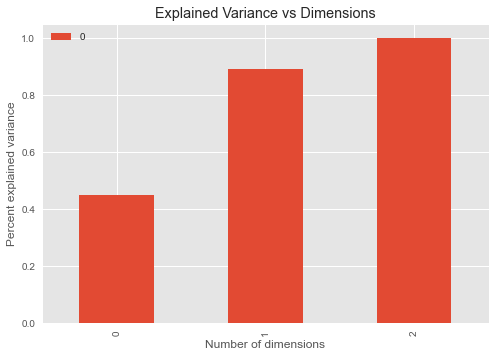

In [49]:
#Plotting the variance explanation
ax = var.plot(kind='bar')

ax.set(xlabel='Number of dimensions',
       ylabel='Percent explained variance',
       title='Explained Variance vs Dimensions')